Upload kaggle.json File (Kaggle API File)

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"minaseyedi","key":"6510e8ac10106d94c0869743da7e2832"}'}

Create Directory and Move Kaggle API to Colab

In [ ]:
!rm -r ~/.kaggle #Remove Old Kaggle Directory
!mkdir ~/.kaggle #Create Kaggle Directory
!mv ./kaggle.json ~/.kaggle/ #Move kaggle.json in Directory
!chmod 600 ~/.kaggle/kaggle.json #Allocate the Required Permission for File.
!kaggle datasets list #Show List of Dataset

rm: cannot remove '/root/.kaggle': No such file or directory
ref                                                             title                                                size  lastUpdated          downloadCount  voteCount  usabilityRating  
--------------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
meirnizri/covid19-dataset                                       COVID-19 Dataset                                      5MB  2022-11-13 15:47:17           7602        232  1.0              
madhurpant/world-deaths-and-causes-1990-2019                    World Deaths and Causes (1990 - 2019)               442KB  2022-11-29 07:09:27           1470         36  1.0              
thedevastator/jobs-dataset-from-glassdoor                       Salary Prediction                                     3MB  2022-11-16 13:52:31           4905        110  1.0              

Upload Dataset from Kaggle to Colab

In [ ]:
!kaggle datasets download -d umangjpatel/ham10000-imagenet-style-dataset

100% 2.58G/2.58G [02:11<00:00, 23.0MB/s]
100% 2.58G/2.58G [02:11<00:00, 21.0MB/s]


Unzip Dataset

In [ ]:
!unzip ham10000-imagenet-style-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: nv/ISIC_0026994.jpg     
  inflating: nv/ISIC_0026997.jpg     
  inflating: nv/ISIC_0026998.jpg     
  inflating: nv/ISIC_0026999.jpg     
  inflating: nv/ISIC_0027000.jpg     
  inflating: nv/ISIC_0027001.jpg     
  inflating: nv/ISIC_0027002.jpg     
  inflating: nv/ISIC_0027003.jpg     
  inflating: nv/ISIC_0027005.jpg     
  inflating: nv/ISIC_0027007.jpg     
  inflating: nv/ISIC_0027009.jpg     
  inflating: nv/ISIC_0027010.jpg     
  inflating: nv/ISIC_0027011.jpg     
  inflating: nv/ISIC_0027012.jpg     
  inflating: nv/ISIC_0027013.jpg     
  inflating: nv/ISIC_0027014.jpg     
  inflating: nv/ISIC_0027015.jpg     
  inflating: nv/ISIC_0027016.jpg     
  inflating: nv/ISIC_0027019.jpg     
  inflating: nv/ISIC_0027020.jpg     
  inflating: nv/ISIC_0027022.jpg     
  inflating: nv/ISIC_0027024.jpg     
  inflating: nv/ISIC_0027028.jpg     
  inflating: nv/ISIC_0027029.jpg     
  inflating: nv/ISIC_0027031.jpg     

Import torch Library and VGG-19 Model

In [ ]:
!pip install torchmetrics

import os
import cv2
import torch
import torchvision
import numpy as np
from PIL import Image
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.nn.functional as F
from skimage.util import random_noise
from torchvision.transforms import transforms
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from torchmetrics.classification import MulticlassF1Score
from torchmetrics.classification import MulticlassAccuracy
from torchmetrics.classification import MulticlassPrecision

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Create Device

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

Dowenload  VGG19_BN Model 

In [ ]:
VGG19 = torchvision.models.vgg19_bn(weights=True)
VGG19

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Create MY_Data Class for Preprocess and Create one-hot Label 

In [ ]:
class My_Data():
  def __init__(self, x):
    self.x = x
    preprocess = transforms.Compose([
        transforms.ToTensor(),
        transforms.RandomCrop(size=(64, 64)),
        transforms.RandomAffine(0),
        # transforms.ColorJitter(brightness=0, contrast=0, saturation=0, hue=0),
        transforms.RandomAutocontrast(p=0.5),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomVerticalFlip(p=0.5),
        transforms.Resize([64, 64])
    ])
    self.preprocess = preprocess

  def __len__(self):
    return len(self.x)

  def __getitem__(self, index):
    image = Image.open(self.x[index][0])
    image = self.preprocess(image)
    image = image.convert("RGB")
    
    label = torch.zeros((3, 1))
    label[self.x[index][1]] = 1
    return image, label

Change Model

In [ ]:
model=nn.Sequential(
    VGG19,
    nn.ReLU(),
    nn.Linear(1000,1000),
    nn.ReLU(),
    nn.Linear(1000,3)
)

Create Optimizer, Loss Function, Accuracy, Precision, and F1Score

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)
loss_function = nn.CrossEntropyLoss()

acc = MulticlassAccuracy(num_classes=3)
pre = MulticlassPrecision(num_classes=3)
f1 = MulticlassF1Score(num_classes=3)

softmax = nn.Softmax(dim = 1)

Add to Device

In [ ]:
model.to(device)
loss_function.to(device)
acc.to(device)
pre.to(device)
f1.to(device)

Create List of Data Classes

In [ ]:
bcc_List, bkl_List, df_List = [], [], []

bcc_path = os.listdir('/content/bcc')
for image_path in bcc_path:
  bcc_List.append(['/content/bcc' + '/' + image_path, 0])
train_list1, test_list1 = train_test_split(bcc_List, test_size = 0.2, random_state=10)
  

bkl_path = os.listdir('/content/bkl')
for image_path in bkl_path:
  bkl_List.append(['/content/bkl' + '/' + image_path, 1])
train_list2, test_list2 = train_test_split(bkl_List, test_size = 0.2, random_state=10)

df_path = os.listdir('/content/df')
for image_path in df_path:
  df_List.append(['/content/df' + '/' + image_path, 2])
train_list3, test_list3 = train_test_split(df_List, test_size = 0.2, random_state=10)

train_list = train_list1+train_list2+train_list3
test_list = test_list1+test_list2+test_list3

Use DataLoader

In [ ]:
train_data = My_Data(train_list)
test_data = My_Data(test_list)

train = DataLoader(train_data, batch_size=50, shuffle=True)
test = DataLoader(test_data, batch_size=50, shuffle=False)

Train Network

In [ ]:
epochs_number = 100
acc_list, train_loss_list, test_loss_list = [], [], []

for epoch in range(epochs_number):
  accuracy, precision, f1score, train_loss, test_loss = [], [], [], [], []
  model.train()
  for data, pred in train:
    data = data.to(device)
    pred = pred.to(device)
    pred = pred.squeeze(2)
    optimizer.zero_grad()
    output = model(data)
    loss = loss_function(output, torch.tensor(pred).to(device))
    loss.backward()
    train_loss.append(loss.item())
    optimizer.step()
  
  with torch.no_grad():
    model.eval()
    for data, pred in test:
      data = data.to(device)
      pred = pred.to(device)
      pred = pred.squeeze(2)
      outputs = model(data)
      outputs = softmax(outputs)
      los = loss_function(outputs, pred)
      test_loss.append(los.item())
      accuracy.append(acc(outputs.cpu(), pred.cpu()))
      precision.append(pre(outputs.cpu(), pred.cpu()))
      f1score.append(f1(outputs.cpu(), pred.cpu()))

    train_loss_list.append(sum(trian_loss)/len(train_loss))
    test_loss_list.append(sum(test_loss)/len(test_loss))
    acc_list.append(sum(accuracy)/len(accuracy)*100)

    if(accuracy[-1]>=max(accuracy)):
      print(f'in epoch {epoch}'+' Model Saved!')
      torch.save(model, 'saved_model.pth')

    print(f'epoch {epoch} : acc {sum(accuracy)/len(accuracy)*100}   pre {sum(precision)/len(precision)*100}   f1 {sum(f1score)/len(f1score)*100}    train {sum(trian_loss)/len(train_loss)}   test {sum(test_loss)/len(test_loss)}')

<ipython-input-14-40034fc4f719>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = loss_function(output,torch.tensor(pred).to(device))


Model Saved in epoch 0!
epoch 0 : acc 75.6190414428711   pre 63.42857360839844   f1 63.42857360839844    train 1.0982084657464708   test 0.9450398938996452
epoch 1 : acc 75.54036712646484   pre 64.79553985595703   f1 60.343414306640625    train 0.8175467721053532   test 0.9276191762515477
epoch 2 : acc 74.8944091796875   pre 65.45880889892578   f1 56.773250579833984    train 0.8182756326028279   test 0.9434661269187927
Model Saved in epoch 3!
epoch 3 : acc 76.38095092773438   pre 64.92865753173828   f1 62.64634704589844    train 0.8380569304738726   test 0.9519747069903782
epoch 4 : acc 70.633544921875   pre 56.278438568115234   f1 54.763404846191406    train 0.8028660693338939   test 0.9727574842316764
Model Saved in epoch 5!
epoch 5 : acc 77.33333587646484   pre 65.88819885253906   f1 65.20598602294922    train 0.8224628652845111   test 0.9538033860070365
epoch 6 : acc 77.0641860961914   pre 63.869049072265625   f1 53.1077995300293    train 0.7992291471787861   test 0.927938929625919

Accuracy Plot

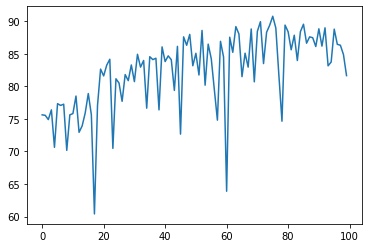

In [ ]:
import matplotlib.pyplot as plt
plt.plot(acc)
plt.show()

Train and Test Plot

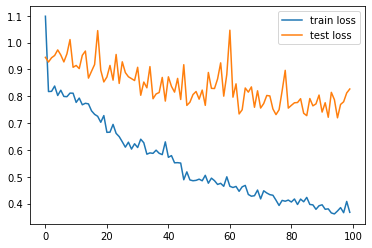

In [ ]:
plt.plot(loss_train)
plt.plot(loss_test)
plt.legend(['train loss', 'test loss'])
plt.show()

Test the Best Model and Print Accuracy, Precision, f1score, and Test Loss

In [ ]:
model.eval() 

datas = torch.Tensor().to('cuda')
preds = torch.Tensor().to('cuda')
acc_list, pre_list, f1_list, test_loss_list = [], [], [], []

with torch.no_grad():
  for data, pred in test:
    data = data.to(device)
    pred = pred.to(device)
    pred = pred.squeeze(2)
    outputs = model(data)
    outputs = softmax(outputs)
    los = loss_function(outputs, pred)
    test_loss_list.append(los.item())
    acc_list.append(acc(outputs.cpu(), pred.cpu()))
    pre_list.append(pre(outputs.cpu(), pred.cpu()))
    f1_list.append(f1(outputs.cpu(), pred.cpu()))
    datas = torch.cat((datas, pred))
    preds = torch.cat((preds, outputs))

  print(f'accuracy : {sum(acc_list)/len(acc_list)}')
  print(f'precision : {sum(pre_list)/len(pre_list)}')
  print(f'f1score : {sum(f1_list)/len(f1_list)}')
  print(f'test_loss : {sum(test_loss_list)/len(test_loss_list)}')

accuracy : 0.9112215638160706
precision : 0.8769684433937073
f1score : 0.8624879717826843
test_loss : 0.7469289001527724


Find True Test Data and Prediction of Test Data

In [ ]:
true = []
for i in range(len(preds)):
  true.append(torch.argmax(preds[i]).item())
print(true)

prediction = []
for i in range(len(datas)):
  prediction.append(torch.argmax(datas[i]).item())
print(prediction)

[0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 

Plot Confusion Matrix

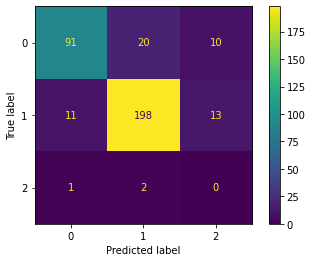

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
con_mat = confusion_matrix(true, prediction)
ConfusionMatrixDisplay(con_mat).plot()